In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.interpolate import CubicSpline
from scipy import stats
import networkx as nx
from itertools import combinations
import scipy

In [3]:
%run data_pipeline.ipynb

########## Data pipeline ##########

Preparing CMU data
379 movies shared both name and release year, dropping
314 movies had actors with the same name, dropping

Merging Oscar dataset, after merge:
Number of different Oscar nominated movies in dataset: 952 in total 63968 different movies
Number of different Oscar nominated actors in dataset: 801 in total 134907 different actors
Number of Oscar nominated rows: 1443

Merging IMDb dataset, after merge:
Number of movies with ratings: 36758
Oscar nominated movies with rating: 939
Number of rows in data before cleaning:  443504
Number of rows in data after cleaning:  23819
Number of rows where age is < 0: 7 . Dropping these rows

FINAL STATE OF DATA
Number of rows:  23812
Number of different Oscar nominated movies in dataset: 394 in total 5987 different movies
Number of different Oscar nominated actors in dataset: 284 in total 2959 different actors
Number of Oscar nominated rows: 519
Processing done, dataset written to cache/data.csv


In [4]:
# Read data
df = pd.read_csv('cache/data.csv', sep=',', index_col=0)
unclean_df = pd.read_csv('cache/unclean_data.csv', sep=',', index_col=0)

In [5]:
df.head()

,title,box_office_revenue,runtime,languages,countries,genres,movie_identifier,actor_gender,actor_height,actor_ethnicity,...,identifier,category,winner,oscar_nominated,year,average_rating,number_of_votes,number_of_movies_starred_in,average_rating_previous_movies,average_box_office_revenue_previous_movies
140029,Down to You,24419914,92,"['French Language', 'English Language']",['United States of America'],"['Romantic comedy', 'Romance Film', 'Drama', '...",down to you_2000,M,1.88,/m/0xnvg,...,down to you_2000_adam carolla,NaN,NaN,False,2000,5.0,15878,1,5.000000,24419914.0
60320,The Bible: In The Beginning,34900023,171,['English Language'],"['United States of America', 'Italy']","['Christian film', 'Drama', 'Epic', 'World cin...",the bible in the beginning_1966,M,1.85,/m/03bkbh,...,the bible in the beginning_1966_richard harris,NaN,NaN,False,1966,6.2,6385,1,6.200000,34900023.0
389034,Hawaii,34562222,161,['English Language'],['United States of America'],"['Period piece', 'Roadshow theatrical release'...",hawaii_1966,M,1.85,/m/03bkbh,...,hawaii_1966_richard harris,NaN,NaN,False,1966,6.5,3708,1,12.700000,69462245.0
130002,Camelot,31102578,178,['English Language'],['United States of America'],"['Costume drama', 'Musical', 'Roadshow theatri...",camelot_1967,M,1.85,/m/03bkbh,...,camelot_1967_richard harris,NaN,NaN,False,1967,6.6,7624,2,9.650000,50282411.5
182566,Caprice,4075000,95,['English Language'],['United States of America'],"['Romantic comedy', 'Crime Fiction', 'Mystery'...",caprice_1967,M,1.85,/m/03bkbh,...,caprice_1967_richard harris,NaN,NaN,False,1967,5.5,1761,3,8.266667,34879941.0


## **Actor Network Analysis**

In [6]:
oscar_nominated = df[df['oscar_nominated']==True]

df_new_movies = df


In [7]:
print(len(df_new_movies), len(df))

23812 23812


In [8]:
G = nx.Graph()

for _, row in df_new_movies.iterrows():
    G.add_node(row['actor_identifier'], oscar_nominated=row['oscar_nominated'])


for movie, group in df_new_movies.groupby('title'):
    actors = group['actor_identifier'].tolist()
    for actor1, actor2 in combinations(actors, 2):
        if G.has_edge(actor1, actor2):
            G[actor1][actor2]['movies'].append(movie)
        else:
            G.add_edge(actor1, actor2, movies=[movie])

colors = {True: 'gold', False: 'blue'}
node_colors = [colors[G.nodes[node]['oscar_nominated']] for node in G.nodes]


In [9]:
average_nominated_degree = []
average_not_nominated = []
degree_dict = dict(G.degree())
for node, degree in degree_dict.items():
    nominated = G.nodes[node]['oscar_nominated']
    if nominated: 
        average_nominated_degree.append(G.degree(node))
    else: 
        average_not_nominated.append(G.degree(node))

print(np.mean(average_not_nominated))
print(np.mean(average_nominated_degree))

37.17391304347826
72.8


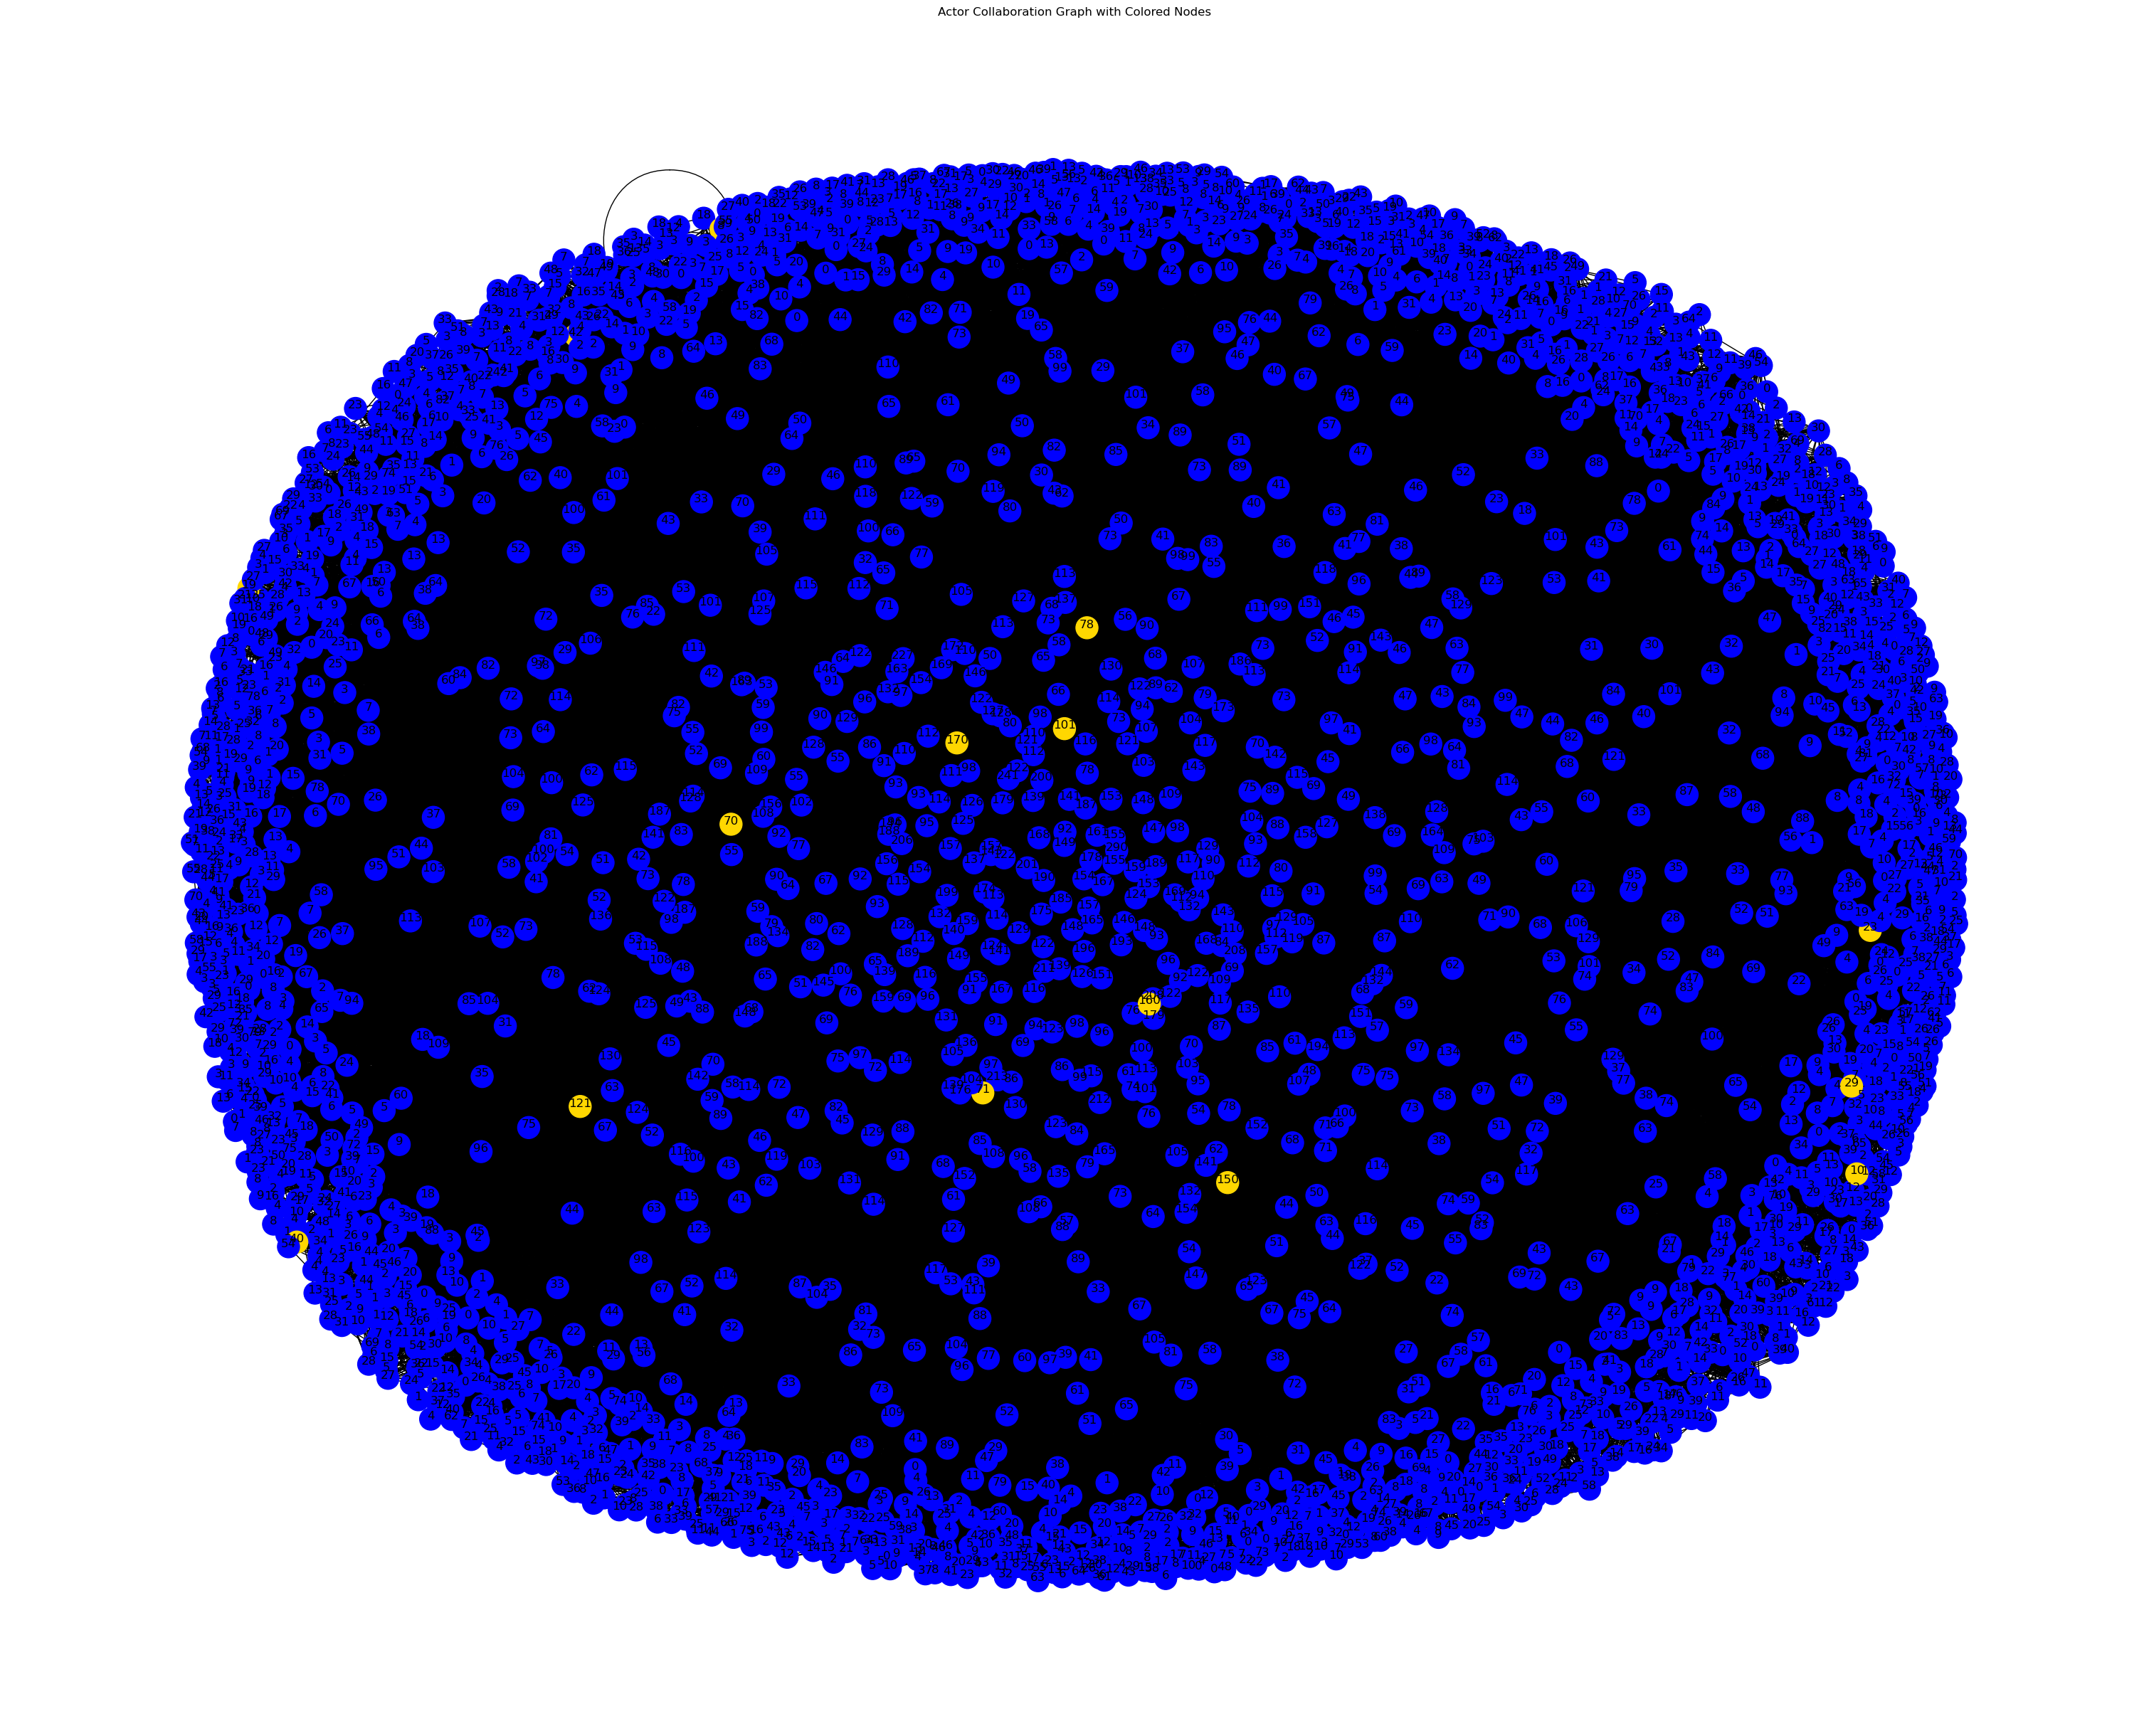

In [10]:
plt.figure(figsize=(30, 24))  
pos = nx.spring_layout(G, k=1, iterations=50)  
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=500, font_size=5, font_weight="bold")
degree_dict = dict(G.degree())
for node, degree in degree_dict.items():
    plt.text(pos[node][0], pos[node][1], str(degree), fontsize=12, ha='center', color='black')
    

plt.title("Actor Collaboration Graph with Colored Nodes")
plt.show()

In [11]:
G = nx.Graph()
for movie, group in oscar_nominated.groupby('movie_identifier'):
    actors = group['actor_identifier'].tolist()
    for actor1, actor2 in combinations(actors, 2):
        if G.has_edge(actor1, actor2):
            G[actor1][actor2]['movies'].append(movie)
        else:
            G.add_edge(actor1, actor2, movies=[movie])



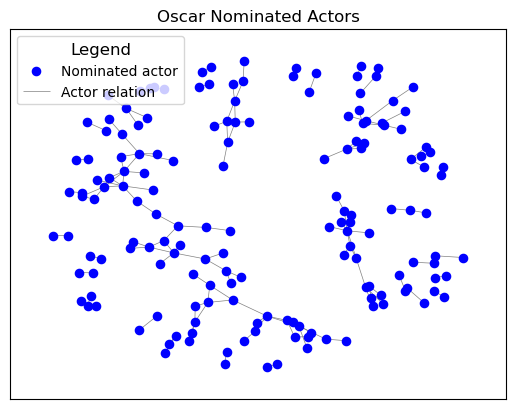

In [12]:
pos = nx.spring_layout(G, k=0.15, iterations=50) 
nx.draw_networkx_nodes(
    G, pos,
    node_color='blue',
    node_size=35,
    label='Nominated actor'  
)


# Draw edges (no label to avoid confusion in the legend)
nx.draw_networkx_edges(
    G, pos,
    width=0.5,
    edge_color='gray', 
    label = 'Actor relation'
)


plt.legend
plt.title('Oscar Nominated Actors')
plt.legend(
    loc='upper left',  # Position of the legend
    title="Legend",    # Title for the legend
    fontsize='10',
    title_fontsize='12'
)

## **Historic movie industry development**

The movie industry has like the economy grown exponentially during the last 100 years. Hence one might expect higher demands and more competition for each Oscar nomination. It is nevertheless interesting and needed to validate this hypothesis with data. We start with constructing the dataframes used for the analysis, then plot the development of movie releases and actor nomnations since the 1920s. 

Constructing df for analysis

In [13]:
# Counting movie releases per year
movie_df = df.drop_duplicates(subset='movie_identifier', keep='first', inplace=False)[['movie_identifier', 'year']]
movie_releases = movie_df.groupby('year').size().reset_index(name='count')
movie_releases.head()

,year,count
0,1928,1
1,1929,1
2,1930,1
3,1932,3
4,1933,5


In [14]:
# Counting oscar nominations per year
oscar_nominations = oscar_nominated.groupby('year').size().reset_index(name='count')
years = pd.DataFrame({'year': movie_releases['year'].unique()})
oscar_nominations = years.merge(oscar_nominations, on='year', how='left').fillna(0)
oscar_nominations.head()

,year,count
0,1928,0.0
1,1929,0.0
2,1930,0.0
3,1932,0.0
4,1933,0.0


In [15]:
# Counting nominated movies per year
nominations_per_movie_per_year = oscar_nominated.groupby(['year', 'movie_identifier']).agg({'title':'count'}).reset_index().rename(columns={'title':'count'})
unique_nominated_movies_per_year = nominations_per_movie_per_year.groupby(['year']).agg({'movie_identifier':'count'}).reset_index().rename(columns={'movie_identifier':'count'})
unique_nominated_movies_per_year.head()

,year,count
0,1934,1
1,1936,1
2,1939,3
3,1940,1
4,1941,1


In [16]:
# Merging releases and nominated movies per year
movie_releases_with_nominations = movie_releases.merge(unique_nominated_movies_per_year, on='year', how='left').fillna(0).rename(columns={'count_x' : 'releases', 'count_y':'nominated movies'})
movie_releases_with_nominations.head()

,year,releases,nominated movies
0,1928,1,0.0
1,1929,1,0.0
2,1930,1,0.0
3,1932,3,0.0
4,1933,5,0.0


In [17]:
# Merging nr. of oscar nominations per year
releases_nominations_counts_df = movie_releases_with_nominations.merge(oscar_nominations, on='year', how='left').fillna(0).rename(columns={'count' : 'oscar nominations'})
releases_nominations_counts_df.head()

,year,releases,nominated movies,oscar nominations
0,1928,1,0.0,0.0
1,1929,1,0.0,0.0
2,1930,1,0.0,0.0
3,1932,3,0.0,0.0
4,1933,5,0.0,0.0


In [18]:
# Calculating % of movies that was nominated each year
releases_nominations_counts_df['%nominated'] = releases_nominations_counts_df['nominated movies'] / releases_nominations_counts_df['releases']
releases_nominations_counts_df.head()

,year,releases,nominated movies,oscar nominations,%nominated
0,1928,1,0.0,0.0,0.0
1,1929,1,0.0,0.0,0.0
2,1930,1,0.0,0.0,0.0
3,1932,3,0.0,0.0,0.0
4,1933,5,0.0,0.0,0.0


**Plotting**

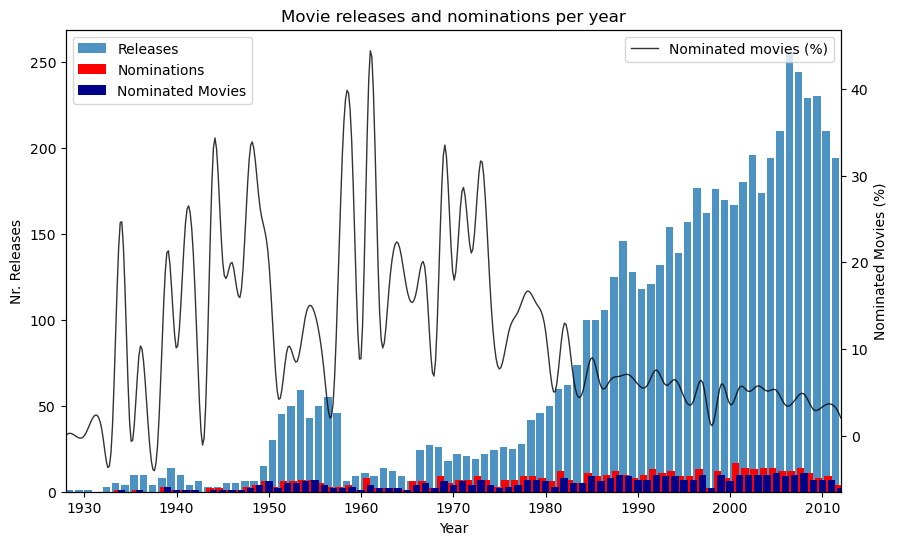

In [19]:
plt.figure(figsize=(10, 6))

plt.bar(releases_nominations_counts_df['year']+0.4, releases_nominations_counts_df['releases'], label ='Releases', alpha=0.8)
plt.bar(releases_nominations_counts_df['year']-0.4, releases_nominations_counts_df['oscar nominations'], label ='Nominations', color='red')
plt.bar(releases_nominations_counts_df['year'], releases_nominations_counts_df['nominated movies'], label ='Nominated Movies', color='#00008B')


plt.xlabel('Year')
plt.xlim(min(df['year']), max(df['year']))

plt.ylabel('Nr. Releases')

plt.legend()

plt.title('Movie releases and nominations per year')


x = releases_nominations_counts_df['year']
y = releases_nominations_counts_df['%nominated']

cs = CubicSpline(x, y)

x_smooth = np.linspace(min(x), max(x), 500)
y_smooth = cs(x_smooth)
ax2 = plt.twinx()
ax2.set_ylabel('Share')
ax2.plot(x_smooth, 100*y_smooth, color='black', label='Nominated movies (%)', alpha=0.8, linewidth=1)

ax2.set_ylabel('Nominated Movies (%)')
plt.legend()
plt.show()


In [20]:
!pip install plotly

In [43]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Bar(y=releases_nominations_counts_df['releases'], x=releases_nominations_counts_df['year'], name="Movie releases"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(y=100*y_smooth, x=x_smooth, name=f"% of movies with nominated a actor"),
    secondary_y=True,
    
)

fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Nr. of movies", secondary_y=False)
fig.update_yaxes(title_text="%", secondary_y=True)
fig.update_layout(
    title_text="Movie relases and percentage of movies with an Oscar nominated actor since 1928"
)
fig.write_html("test2.html")




Clearly, the number of movie releases per year has fluctuated during the last 100 years. However, since the 1960, the number of movie releases has been on a steady uptrend, until the 2010s. In the meantime, the share of movies that has nominated actors has decreased dramatically from 20-40% in thw 30s-70s to far below 10% in the 2010s. 

## Genre

To maximize the likelihood of winning an oscar, may have to choose genre wisely. We will below analyse what genres are relatively likely to to have oscar nominated actors, and what genres have relatively few actor nominations. 

Constructing dataframe for analysis

In [237]:
# Making a copy for this part
genre_df = df.copy()

In [238]:
# One nan value, filling with no genres, i.e. [] 
genre_df['genres'] = genre_df['genres'].fillna('[]')

# Splitting each entry in the genre column into lists of genres. 
genre_lists = genre_df['genres'].apply(lambda x: x[1:-1].split(', ') if x != '[]' else [])

# Removing "" from each list in genre_lists: "'Thriller'" -> 'Thriller'
genre_lists = genre_lists.apply(lambda x: [g[1:-1] for g in x])

# Removing emtpy entries in the lists: 
genre_lists = genre_lists.apply(lambda x: [g for g in x if g != ''] )

# Creating a set of all genres. 
all_genres = set([genre for sublist in genre_lists for genre in sublist])

# Resetting index
genre_df = genre_df.reset_index(drop=True)

Now we build a dictionary mapping each genre to a list of 1s and 0s that indicates for each movie if they had that genre. 

In [239]:
# Adding all genres as keys to the dictionary
genre_dict = {}
for g in all_genres:
    genre_dict[g] = []

# For each movie, for each genre, we append a 1 if the genre was in the movie, else 0
for movie_genres in genre_lists:  
    for g in all_genres:
        if g in movie_genres: 
            genre_dict[g].append(1)
        else: genre_dict[g].append(0)

In [240]:
# Each genre has now a list indicating if what movies has that genre
print('Length: ', len(genre_dict['Thriller']))
print(genre_dict['Thriller'][:10])

Length:  23812
[0, 0, 0, 0, 1, 0, 1, 0, 0, 1]


The first three movies have the genre thriller. We verify this below. 

Now we add our dictionary data to the genre_df dataframe. 

In [ ]:
genre_df = pd.concat([genre_df.reset_index(drop=True), pd.DataFrame(genre_dict).reset_index(drop=True)], axis=1)

In [261]:
genre_df_oscar_nominated = genre_df[genre_df['oscar_nominated'] == True]

In [262]:
print('Nr. of columns in new df: ', genre_df_oscar_nominated.columns.shape)
print('Example genres: ', genre_df_oscar_nominated.columns[100:104].values)

Nr. of columns in new df:  (283,)
Example genres:  ['Art film' 'Female buddy film' 'Propaganda film' 'Live action']


Now we take only the genre columns, from column index 20. We sum each column, getting the nr. of appearances for each genre. 

In [263]:
genre_frequencies = genre_df.iloc[:,23:].sum(axis=0).sort_values(ascending=False)
nominated_genre_frequencies = genre_df_oscar_nominated.iloc[:,23:].sum(axis=0)
nominated_genre_frequencies = nominated_genre_frequencies.reindex(genre_frequencies.index)

In [264]:
assert nominated_genre_frequencies.index.all() == genre_frequencies.index.all()

Standardisation and normalization of data

In [265]:
genre_frequencies_df = pd.DataFrame({'all': genre_frequencies, 'nominated': nominated_genre_frequencies})

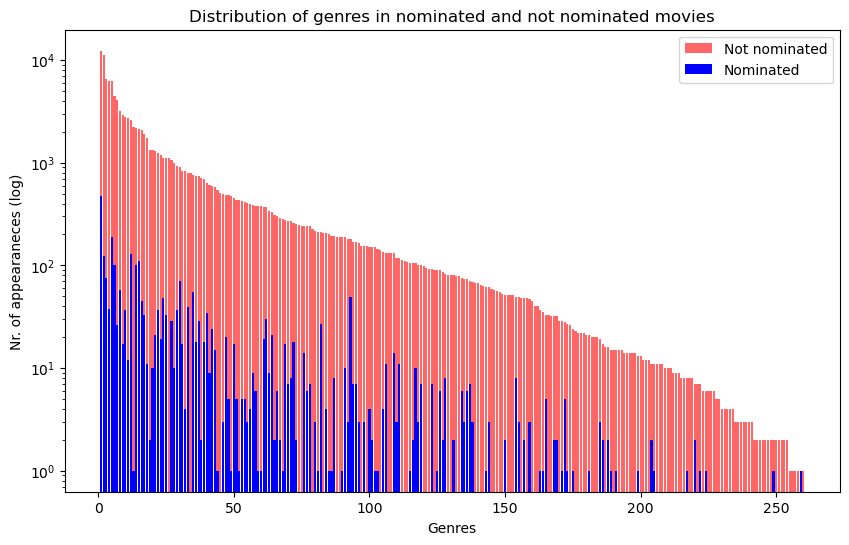

In [255]:
plt.figure(figsize=(10, 6))
plt.bar(np.arange(1, len(genre_frequencies)+1), genre_frequencies_df['all'], color='red', alpha=0.6,label='Not nominated')
plt.bar(np.arange(1, len(genre_frequencies)+1), genre_frequencies_df['nominated'],color='blue', label='Nominated')
plt.title('Distribution of genres in nominated and not nominated movies')
plt.yscale('log')
plt.ylabel('Nr. of appearaneces (log)')
plt.xlabel('Genres')
plt.legend()

We can clearly see that the distributions are similair, but that the nominated movies have several genres with no nominations. To test if these are the same probability distributions we use the Kolmogorov-Smirnov test implemented in scipy stats. 

In [256]:
scipy.stats.kstest(nominated_genre_frequencies, genre_frequencies)

KstestResult(statistic=0.6192307692307693, pvalue=6.32944883717225e-47, statistic_location=7, statistic_sign=1)

P-value: 3.0311703148734133e-21
statistic=0.4230769230769231

The extremely small P-value indicates that we can confidently say that the distributions are different. However, a statistic of 0.42 indicates that eventhough the distributions are different, they are not that dissimilar. 

We take a further look into the genres that have no nominated appearances: 

In [269]:
# Creating a new column that will be true if it has no nominated appearances. 
genre_frequencies_df['top_non_nominated_genres'] = False
mask = genre_frequencies_df['nominated'] == 0
genre_frequencies_df.loc[mask, 'top_non_nominated_genres'] = True

In [273]:
# Selecting all the genres that does not have any nominated appearances and saving to not_nominated_genres_df. 
not_nominated_genres_df = genre_frequencies_df.loc[genre_frequencies_df['top_non_nominated_genres'] == True,:].reset_index()
not_nominated_genres_df = not_nominated_genres_df.rename(columns={'index':'genre'})
print(not_nominated_genres_df.head())
print(not_nominated_genres_df.shape)

                genre   all  nominated  top_non_nominated_genres
0           Animation  1104          0                      True
1           Slapstick   786          0                      True
2  Computer Animation   505          0                      True
3           Absurdism   245          0                      True
4       Doomsday film   243          0                      True
(116, 4)


116 Genres have no oscar nominated actors. Some of these genres are self explanatory e.g. Animation. However we need further analysis to get a deeper understanding. 

<BarContainer object of 21 artists>

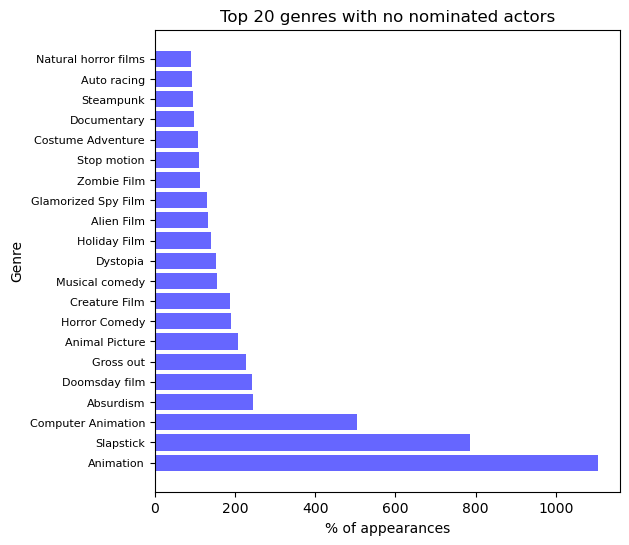

In [275]:
plt.figure(figsize=(6,6))
not_nominated_genres_df.iloc[:20,:]
labels = not_nominated_genres_df.loc[:20,'genre']
plt.yticks(np.arange(1,len(labels)+1), labels=labels, fontsize=8)
plt.xlabel('% of appearances')
plt.ylabel('Genre')
plt.title('Top 20 genres with no nominated actors')
plt.barh(np.arange(1, len(not_nominated_genres_df.iloc[:20,:])+2), not_nominated_genres_df.loc[:20,'all'], color='blue', alpha=0.6, label='Not nominated')


In [303]:
genre_frequencies_df['share_nominated'] = genre_frequencies_df['nominated'] / genre_frequencies_df['all']

In [308]:
genre_frequencies_df = genre_frequencies_df[genre_frequencies_df['nominated'] > 1].sort_values(by='nominated', ascending=False)

In [309]:
top_20_df = genre_frequencies_df.iloc[:20,:].sort_values(by='nominated', ascending=False)

In [324]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        y=not_nominated_genres_df.loc[:20,'genre'],  
        x=not_nominated_genres_df.loc[:20,'all'],     
        orientation='h',  
        name="Number of performances. 1928-2012",
        text=not_nominated_genres_df.loc[:20,'all'], 
        textposition='outside',
        marker=dict(color='blue')     
    ),
)

fig.update_layout(
    title='Biggest genres without Oscar nominated performance',
    xaxis_title='Nr. of performances',
    yaxis_title='Genres',
    barmode='stack',  
    template='plotly',  
    showlegend=True     
)

fig.write_html('worst_genres.html')

In [335]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    y=top_20_df.index,   
    x=[p * f for p, f in zip(top_20_df['share_nominated'], top_20_df['all'])], 
    orientation='h',
    name='Nominated performance',
    marker=dict(color='red'), 
))

fig.add_trace(go.Bar(
    y=top_20_df.index,   
    x=top_20_df['all'],  
    orientation='h',      
    name='Not nominated performances',
    marker=dict(color='blue'),
    opacity=0.8, 
))

fig.update_layout(
    title='Most popular genres at the Oscars',
    xaxis_title='Number of appearances',
    yaxis_title='Genres',
    barmode='stack', 
    template='plotly',  
    showlegend=True 
)

fig.write_html('best_genres_abs.html')

In [333]:
genre_frequencies_df = genre_frequencies_df[genre_frequencies_df['nominated'] > 1].sort_values(by='share_nominated', ascending=False)
top_20_df = genre_frequencies_df.iloc[:20,:].sort_values(by='nominated', ascending=False)

In [336]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    y=top_20_df.index,   
    x=[p * f for p, f in zip(top_20_df['share_nominated'], top_20_df['all'])], 
    orientation='h',
    name='Nominated performance',
    marker=dict(color='red'), 
))

fig.add_trace(go.Bar(
    y=top_20_df.index,   
    x=top_20_df['all'],  
    orientation='h',      
    name='Not nominated performances',
    marker=dict(color='blue'),
    opacity=0.8, 
))

fig.update_layout(
    title='Most popular genres at the Oscars',
    xaxis_title='Number of appearances',
    yaxis_title='Genres',
    barmode='stack', 
    template='plotly',  
    showlegend=True 
)

fig.write_html('best_genres_rel.html')

Like eluded to earlier, some genres might be self explanatory. However, there are clearly genres worth avoiding for oscar aspiring actors. For instance Absurdims, doomsday film, dystopia and holiday film to name a few.